In [232]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, RidgeCV
from sklearn.metrics import r2_score
from sklearn.linear_model import lars_path
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics   
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from xgboost import plot_tree
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
import math
from dtreeviz.trees import *
import shap


In [233]:
#import dataset

df = pd.read_csv("salary_final.csv")

In [234]:


df.shape

(1303, 22)

In [235]:
#check for any Nan Values 

df=df.dropna()
df.shape

(1303, 22)

<AxesSubplot:xlabel='Salary', ylabel='Count'>

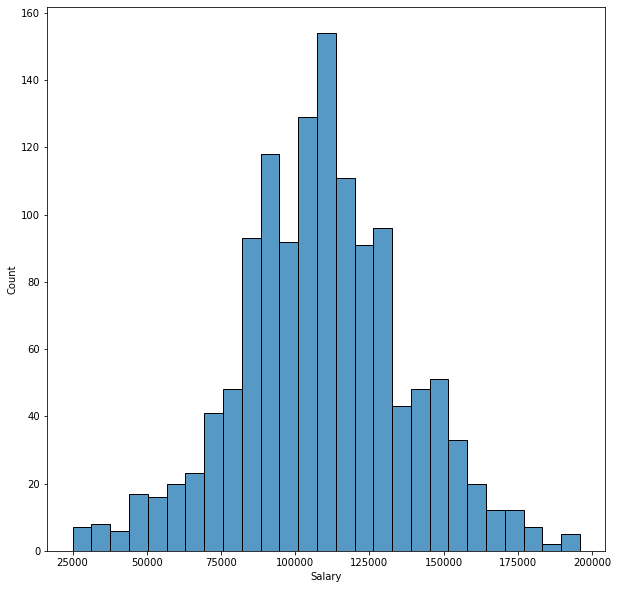

In [236]:
#histogram of base pay 

sns.histplot(data=df, x="Salary")

In [237]:
df.dtypes

Size                 object
Revenue              object
Internship            int64
Cash_Bonus            int64
Stock_Bonus           int64
Total_Pay             int64
Confidence            int64
Reviews               int64
Jobs                  int64
Salaries              int64
Interviews          float64
Benefits              int64
Salary              float64
Company_Type         object
US                   object
COL                 float64
Rent                float64
COL_Plus_Rent       float64
Purchasing_Power    float64
Industry_            object
Age                 float64
Additional_Pay        int64
dtype: object

In [238]:
#standardize numerical variables

num_cols = [ "Reviews", "Jobs", "Salaries", "Interviews", "Benefits", "COL_Plus_Rent", "Purchasing_Power", "COL",
           "Rent", "Age", "Cash_Bonus", "Stock_Bonus", "Additional_Pay", "Internship" , "Confidence", "Total_Pay"]
std = StandardScaler()
std.fit(df[num_cols].values)

#apply

df[num_cols]= std.transform(df[num_cols].values)

In [239]:

#drop NA from df and make dummy variables for categorical predictors 

df_model = pd.get_dummies(df, drop_first = True)
df_model.head()

,Internship,Cash_Bonus,Stock_Bonus,Total_Pay,Confidence,Reviews,Jobs,Salaries,Interviews,Benefits,...,Revenue_Less than 5 billion (USD),Revenue_Unknown / Non-Applicable,Company_Type_Company - Public,Company_Type_Other,Company_Type_Subsidiary or Business Segment,US_NORTH_EAST,US_SOUTH,US_WEST,Industry__Other,Industry__Technology
0,-0.362045,0.626814,0.626814,1.225633,1.440485,1.577339,0.445617,-0.362043,0.864134,0.363869,...,0,0,1,0,0,1,0,0,1,0
1,-0.362045,-0.218842,-0.218842,0.577148,1.440485,0.319054,-0.528353,1.015915,-0.069695,-0.151989,...,0,0,0,1,0,1,0,0,1,0
2,-0.362045,-0.443515,-0.443515,0.520143,1.440485,1.958638,-0.297863,-0.492039,0.898064,0.466733,...,0,0,1,0,0,1,0,0,0,1
3,-0.362045,-0.005180,-0.005180,0.323330,1.440485,-0.881274,-0.537708,-0.758791,-1.079831,-0.642645,...,0,1,0,0,0,1,0,0,1,0
4,-0.362045,-0.443515,-0.443515,0.887780,1.440485,2.073028,0.782372,-0.284046,0.864134,0.466733,...,0,0,1,0,0,1,0,0,1,0


In [240]:

df_model.shape

(1303, 33)

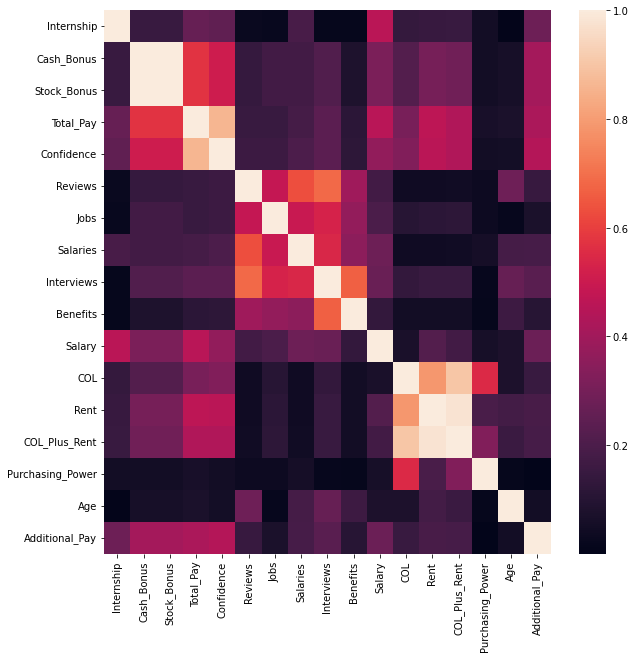

In [241]:
df_corr = df.corr().abs()
hm = sns.heatmap(df_corr)
figure = hm.get_figure()  
figure.savefig('heatmap.png', dpi=400)

In [242]:
#define X and y 

X = df_model.drop( "Salary", axis = 1)
y = df_model["Salary"]

In [243]:
#create a correlation df for the features 

X_corr = X.corr().abs()

In [244]:
#get list of correlations amongst features 

X_corr_list = X_corr.unstack().sort_values(ascending=False).drop_duplicates()
X_corr_list.head(25)

Internship           Internship                       1.000000
Rent                 COL_Plus_Rent                    0.977010
COL                  COL_Plus_Rent                    0.901535
Total_Pay            Confidence                       0.860908
COL                  Rent                             0.788558
Industry__Other      Industry__Technology             0.719665
Interviews           Reviews                          0.685647
Benefits             Interviews                       0.667007
Salaries             Reviews                          0.631153
Size_Less Than 1000  Interviews                       0.623090
Stock_Bonus          Total_Pay                        0.570553
Interviews           Company_Type_Company - Public    0.563102
COL                  Purchasing_Power                 0.549032
Interviews           Salaries                         0.540655
Jobs                 Interviews                       0.529170
US_NORTH_EAST        COL                              0

In [245]:


#Getting list of highly correlated features 
correlated_features = set()
for i in range(len(X_corr.columns)):
    for j in range(i):
        if abs(X_corr.iloc[i, j]) > 0.7:
            colname = X_corr.columns[i]
            correlated_features.add(colname)
print(correlated_features)

{'COL_Plus_Rent', 'Rent', 'Stock_Bonus', 'Industry__Technology', 'Confidence'}


In [246]:
#dropping highly correlated features from the training set 
corr_features = [ 'COL_Plus_Rent', 'Rent', 'Stock_Bonus',]
X.drop(corr_features, axis=1, inplace=True)
X.head()


,Internship,Cash_Bonus,Total_Pay,Confidence,Reviews,Jobs,Salaries,Interviews,Benefits,COL,...,Revenue_Less than 5 billion (USD),Revenue_Unknown / Non-Applicable,Company_Type_Company - Public,Company_Type_Other,Company_Type_Subsidiary or Business Segment,US_NORTH_EAST,US_SOUTH,US_WEST,Industry__Other,Industry__Technology
0,-0.362045,0.626814,1.225633,1.440485,1.577339,0.445617,-0.362043,0.864134,0.363869,-0.330475,...,0,0,1,0,0,1,0,0,1,0
1,-0.362045,-0.218842,0.577148,1.440485,0.319054,-0.528353,1.015915,-0.069695,-0.151989,-0.330475,...,0,0,0,1,0,1,0,0,1,0
2,-0.362045,-0.443515,0.520143,1.440485,1.958638,-0.297863,-0.492039,0.898064,0.466733,-0.330475,...,0,0,1,0,0,1,0,0,0,1
3,-0.362045,-0.005180,0.323330,1.440485,-0.881274,-0.537708,-0.758791,-1.079831,-0.642645,-0.330475,...,0,1,0,0,0,1,0,0,1,0
4,-0.362045,-0.443515,0.887780,1.440485,2.073028,0.782372,-0.284046,0.864134,0.466733,-0.330475,...,0,0,1,0,0,1,0,0,1,0


In [247]:
#documentation shows VIf assumes constant is present in the dataset.
#the constant will be added before running vif.
#https://github.com/statsmodels/statsmodels/issues/2376

#X = sm.add_constant(X)

In [248]:
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [249]:
X.shape

(1303, 29)

In [250]:
X_vif = vif(X)
X_vif.sort_values(ascending=False)

Interviews                                     5.327276
Size_Less Than 1000                            5.046999
Total_Pay                                      4.548280
Confidence                                     4.274093
Revenue_Less than 5 billion (USD)              4.164243
Revenue_Unknown / Non-Applicable               4.003778
Company_Type_Company - Public                  3.635548
Industry__Other                                3.489826
Industry__Technology                           3.402164
COL                                            2.920407
Reviews                                        2.785701
US_WEST                                        2.704225
Size_1001 to 5000 Employees                    2.614231
US_NORTH_EAST                                  2.484045
Benefits                                       2.072239
Salaries                                       2.042651
Company_Type_Other                             1.904738
Purchasing_Power                               1

In [251]:
#remove high inflation factors
high_vif = [ "Interviews"]
X.drop(high_vif, axis=1, inplace=True)
X.head()

,Internship,Cash_Bonus,Total_Pay,Confidence,Reviews,Jobs,Salaries,Benefits,COL,Purchasing_Power,...,Revenue_Less than 5 billion (USD),Revenue_Unknown / Non-Applicable,Company_Type_Company - Public,Company_Type_Other,Company_Type_Subsidiary or Business Segment,US_NORTH_EAST,US_SOUTH,US_WEST,Industry__Other,Industry__Technology
0,-0.362045,0.626814,1.225633,1.440485,1.577339,0.445617,-0.362043,0.363869,-0.330475,0.152482,...,0,0,1,0,0,1,0,0,1,0
1,-0.362045,-0.218842,0.577148,1.440485,0.319054,-0.528353,1.015915,-0.151989,-0.330475,0.152482,...,0,0,0,1,0,1,0,0,1,0
2,-0.362045,-0.443515,0.520143,1.440485,1.958638,-0.297863,-0.492039,0.466733,-0.330475,0.152482,...,0,0,1,0,0,1,0,0,0,1
3,-0.362045,-0.005180,0.323330,1.440485,-0.881274,-0.537708,-0.758791,-0.642645,-0.330475,0.152482,...,0,1,0,0,0,1,0,0,1,0
4,-0.362045,-0.443515,0.887780,1.440485,2.073028,0.782372,-0.284046,0.466733,-0.330475,0.152482,...,0,0,1,0,0,1,0,0,1,0


In [252]:
#get shape of  X and y 

print(X.shape, y.shape)


(1303, 28) (1303,)


In [253]:
#partition data into test data 

X, X_test, y, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

#partition remaining data into train / validation


X_train, X_val, y_train, y_val = train_test_split (X, y, test_size= .25, random_state = 33)

print( X_test.shape, X_train.shape, X_val.shape)

(261, 28) (781, 28) (261, 28)


In [254]:
#define mae 
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [255]:
#create df to store results
cols = ["TEST","FEAT", "OBS","ALPHA", "MAE", "RMSE", "R2", "ADJ_R2"]
results_df = pd.DataFrame(columns=cols)
results_df.head()

,TEST,FEAT,OBS,ALPHA,MAE,RMSE,R2,ADJ_R2


In [256]:
#Tuning Parameters for XG Boost 

#Convert data into DMatrix
glass_dmatrix = xgb.DMatrix(data = X_train, label = y_train)

# Grid of hyperparameters to search over
param_random_gb = {'learning_rate': np.arange(0.05,1.05, 0.05),
              'n_estimators' : [200],
              'subsample' : np.arange(0.05,1.05, 0.05),
                   'alpha': (0.05, 0.1, 0.2, 0.3, 0.5)
                   }

# Regressor Instantiation
gb = xgb.XGBRegressor()

# 25 iterations
mse_random = RandomizedSearchCV(estimator = gb, param_distributions = param_random_gb, n_iter = 25, 
                                scoring = 'neg_mean_squared_error', cv = 4, verbose = 1)

mse_random.fit(X,y)

print("Best parameter: ", mse_random.best_params_)
print("Lowest RMSE: ", np.sqrt(np.abs(mse_random.best_score_)))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameter:  {'subsample': 0.8, 'n_estimators': 200, 'learning_rate': 0.05, 'alpha': 0.3}
Lowest RMSE:  18365.555036403384


In [257]:
#Train XG Boost Model
xgbr = xgb.XGBRegressor(verbosity=0, eta=0.05, sub_sample=0.8, n_estimators=200, alpha=0.3) 
xgbr.fit(X_train, y_train)


#Create kFold cross-val score 
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )

#predict y values 
y_pred = xgbr.predict(X_val)

#derive mse, score, mae and adjusted r2
mse = mean_squared_error(y_val, y_pred)
score = xgbr.score(X_val, y_val)
xgb_mae = mae(y_val, y_pred)

#get adjust r2 for the model 
#Adj r2 = 1-(1-R2)*(n-1)/(n-p-1)
adj_r2 = 1-(1-score) * (261-1)/(261-28-1)

print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("MAE Score %.2f" % xgb_mae)
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print ("R2 Score: %.2f" % score )
print("Adjusted R2 Score: %.2f" % adj_r2)

results_df.loc[0] = ["XG_BOOST", 28, 261, 0.5, xgb_mae,
             mse**(1/2.0), score, adj_r2]
results_df.head()

MSE: 401988344.31
RMSE: 20049.65
MAE Score 13268.80
K-fold CV average score: 0.60
R2 Score: 0.50
Adjusted R2 Score: 0.45


,TEST,FEAT,OBS,ALPHA,MAE,RMSE,R2,ADJ_R2
0,XG_BOOST,28,261,0.5,13268.799419,20049.646987,0.504787,0.445019


In [258]:
## Creating LARS Path

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_train.values, y_train.values, method='lasso')

Computing regularization path using the LARS ...


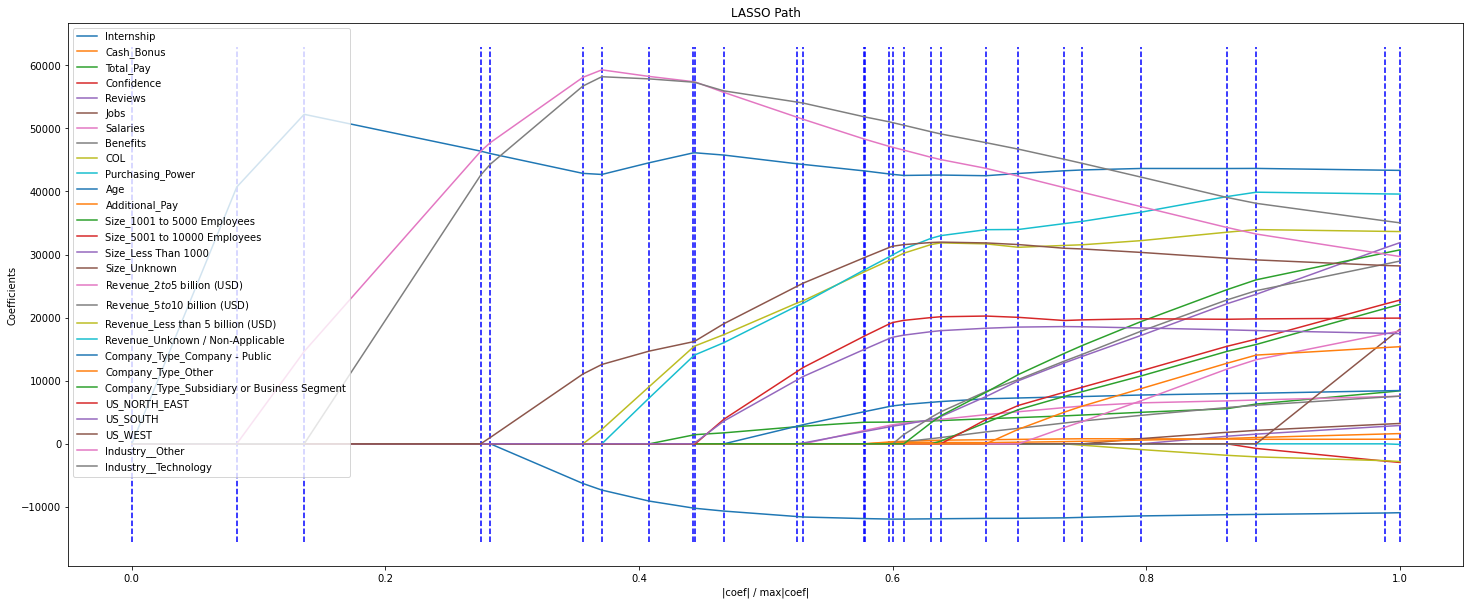

In [259]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(25,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed', color = "blue")
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')

plt.legend(X_train.columns)
plt.savefig('Lasso_LARS_path_train.png')
plt.show()

In [260]:
#Using Lasso on train data 

alphas = 100000**np.linspace(-2,2,1000)
Glassdoor_Lasso = LassoCV(alphas = alphas,
                             
                             cv=5, random_state=33)


Glassdoor_Lasso.fit(X_train, y_train)


LassoCV(alphas=array([1.00000000e-10, 1.04717682e-10, 1.09657929e-10, 1.14831241e-10,
       1.20248614e-10, 1.25921561e-10, 1.31862140e-10, 1.38082977e-10,
       1.44597292e-10, 1.51418933e-10, 1.58562396e-10, 1.66042866e-10,
       1.73876240e-10, 1.82079168e-10, 1.90669084e-10, 1.99664245e-10,
       2.09083769e-10, 2.18947676e-10, 2.29276931e-10, 2.40093488e-10,
       2.51420335e-10, 2.63281547e-1...
       3.46369418e+09, 3.62710025e+09, 3.79821531e+09, 3.97740302e+09,
       4.16504425e+09, 4.36153779e+09, 4.56730127e+09, 4.78277202e+09,
       5.00840799e+09, 5.24468875e+09, 5.49211648e+09, 5.75121707e+09,
       6.02254120e+09, 6.30666554e+09, 6.60419396e+09, 6.91575883e+09,
       7.24202233e+09, 7.58367791e+09, 7.94145172e+09, 8.31610415e+09,
       8.70843150e+09, 9.11926760e+09, 9.54948564e+09, 1.00000000e+10]),
        cv=5, random_state=33)

In [261]:
#Standardized coefficients found
# when refit using that best alpha
list(zip(X_train.columns, Glassdoor_Lasso.coef_))

[('Internship', -12520.91065570821),
 ('Cash_Bonus', 1132.401279434823),
 ('Total_Pay', 10349.088164217748),
 ('Confidence', -3836.7882065107983),
 ('Reviews', 609.8961917958994),
 ('Jobs', 1697.9317969607007),
 ('Salaries', 2141.3431384780356),
 ('Benefits', 549.844416966393),
 ('COL', 0.0),
 ('Purchasing_Power', 995.9432922490219),
 ('Age', -138.6743904891083),
 ('Additional_Pay', -334.5102890982412),
 ('Size_1001 to 5000 Employees', -648.2637826567175),
 ('Size_5001 to 10000 Employees', 4082.324258655918),
 ('Size_Less Than 1000', -2882.619321165442),
 ('Size_Unknown', -0.0),
 ('Revenue_$2 to $5 billion (USD)', -3371.6948806238597),
 ('Revenue_$5 to $10 billion (USD)', 0.0),
 ('Revenue_Less than 5 billion (USD)', -687.6221992890767),
 ('Revenue_Unknown / Non-Applicable', 0.0),
 ('Company_Type_Company - Public', 3752.8858299513754),
 ('Company_Type_Other', -0.0),
 ('Company_Type_Subsidiary or Business Segment', 0.0),
 ('US_NORTH_EAST', -0.0),
 ('US_SOUTH', -697.8730548516637),
 ('US_

In [262]:


# Make predictions on the test set using lasso
y_pred_lasso = Glassdoor_Lasso.predict(X_val)

# Best alpha value found
print("Alpha: " + str(Glassdoor_Lasso.alpha_))

#get mae for lasso cv model
lasso_mae = mae(y_val, y_pred_lasso)
print("MAE: " + str(lasso_mae))


#derive residuals for the model

residuals_lasso = y_val - y_pred_lasso

#define mse and rmse 

lasso_mse = mean_squared_error(y_val, y_pred_lasso)
lasso_rmse = math.sqrt(lasso_mse)

print("RMSE: " + str(lasso_rmse))

#get r2 for lasso model


lasso_r2=r2_score(y_val, y_pred_lasso)
print("R2: " + str(lasso_r2))

#get adjust r2 for the model 
#Adj r2 = 1-(1-R2)*(n-1)/(n-p-1)

lasso_adj_r2 = 1-(1-lasso_r2)*(261-1)/(261-21-1)
print("Adjusted R2: " + str(lasso_adj_r2))

results_df.loc[1] = ["LASSO", 21, 261,Glassdoor_Lasso.alpha_, lasso_mae,
             lasso_rmse, lasso_r2, lasso_adj_r2]
results_df.head()

Alpha: 178.7525525904232
MAE: 17673.359690312675
RMSE: 23379.601916723685
R2: 0.3266309491078184
Adjusted R2: 0.26746463082858907


,TEST,FEAT,OBS,ALPHA,MAE,RMSE,R2,ADJ_R2
0,XG_BOOST,28,261,0.500000,13268.799419,20049.646987,0.504787,0.445019
1,LASSO,21,261,178.752553,17673.359690,23379.601917,0.326631,0.267465


In [263]:
#Using Ridge on train data 

alphas = 10000**np.linspace(-2,2,100)
Glassdoor_Ridge = RidgeCV(alphas = alphas,
                            cv=5)


Glassdoor_Ridge.fit(X_train, y_train)


RidgeCV(alphas=array([1.00000000e-08, 1.45082878e-08, 2.10490414e-08, 3.05385551e-08,
       4.43062146e-08, 6.42807312e-08, 9.32603347e-08, 1.35304777e-07,
       1.96304065e-07, 2.84803587e-07, 4.13201240e-07, 5.99484250e-07,
       8.69749003e-07, 1.26185688e-06, 1.83073828e-06, 2.65608778e-06,
       3.85352859e-06, 5.59081018e-06, 8.11130831e-06, 1.17681195e-05,
       1.70735265e-05, 2.47707636e-0...
       1.91791026e+04, 2.78255940e+04, 4.03701726e+04, 5.85702082e+04,
       8.49753436e+04, 1.23284674e+05, 1.78864953e+05, 2.59502421e+05,
       3.76493581e+05, 5.46227722e+05, 7.92482898e+05, 1.14975700e+06,
       1.66810054e+06, 2.42012826e+06, 3.51119173e+06, 5.09413801e+06,
       7.39072203e+06, 1.07226722e+07, 1.55567614e+07, 2.25701972e+07,
       3.27454916e+07, 4.75081016e+07, 6.89261210e+07, 1.00000000e+08]),
        cv=5)

In [264]:
#Standardized coefficients found
# when refit using that best alpha
list(zip(X_train.columns, Glassdoor_Ridge.coef_))

[('Internship', -12459.082698240087),
 ('Cash_Bonus', 1445.5258692830828),
 ('Total_Pay', 10119.707504671704),
 ('Confidence', -3786.8772538412513),
 ('Reviews', 493.313027385192),
 ('Jobs', 1657.6910444679995),
 ('Salaries', 2114.3215063211996),
 ('Benefits', 536.4808539718928),
 ('COL', 447.2680736523506),
 ('Purchasing_Power', 1365.8351233795001),
 ('Age', -541.4058524010709),
 ('Additional_Pay', -705.81954132024),
 ('Size_1001 to 5000 Employees', -2053.1999141536394),
 ('Size_5001 to 10000 Employees', 4341.821530163611),
 ('Size_Less Than 1000', -3956.780536874946),
 ('Size_Unknown', -1784.3542253997646),
 ('Revenue_$2 to $5 billion (USD)', -4389.336702047719),
 ('Revenue_$5 to $10 billion (USD)', 366.3602177776377),
 ('Revenue_Less than 5 billion (USD)', -1344.905019014341),
 ('Revenue_Unknown / Non-Applicable', 9.380398451020172),
 ('Company_Type_Company - Public', 3693.1903416535397),
 ('Company_Type_Other', -857.2927120292688),
 ('Company_Type_Subsidiary or Business Segment', 1

In [265]:
# Make predictions on the test set using 
y_pred_ridge = Glassdoor_Ridge.predict(X_val)


# Best alpha value found
print("Alpha: " + str(Glassdoor_Ridge.alpha_))

#derive residuals for the model

residuals_ridge = y_val - y_pred_ridge

#get mae for the model
ridge_mae = mae(y_val, y_pred_ridge)
print("MAE: " + str(ridge_mae))

#get RMSE for the model

ridge_mse = mean_squared_error(y_val, y_pred_ridge)
ridge_rmse = math.sqrt(ridge_mse)

print("RMSE: " + str(ridge_rmse))

#get r2 for ridge model


ridge_r2=r2_score(y_val, y_pred_ridge)
print("R2: " + str(ridge_r2))

#get adjust r2 for the model 
#Adj r2 = 1-(1-R2)*(n-1)/(n-p-1)

ridge_adj_r2 = 1-(1-ridge_r2)*(261-1)/(261-28-1)
print("Adjusted R2: " + str(ridge_adj_r2))

results_df.loc[2] = ["RIDGE", 28, 261, Glassdoor_Ridge.alpha_, ridge_mae,
             ridge_rmse, ridge_r2, ridge_adj_r2]
results_df.head()

Alpha: 23.644894126454073
MAE: 17588.233738719526
RMSE: 23294.030979058658
R2: 0.3315510818985027
Adjusted R2: 0.25087621247245995


,TEST,FEAT,OBS,ALPHA,MAE,RMSE,R2,ADJ_R2
0,XG_BOOST,28,261,0.500000,13268.799419,20049.646987,0.504787,0.445019
1,LASSO,21,261,178.752553,17673.359690,23379.601917,0.326631,0.267465
2,RIDGE,28,261,23.644894,17588.233739,23294.030979,0.331551,0.250876


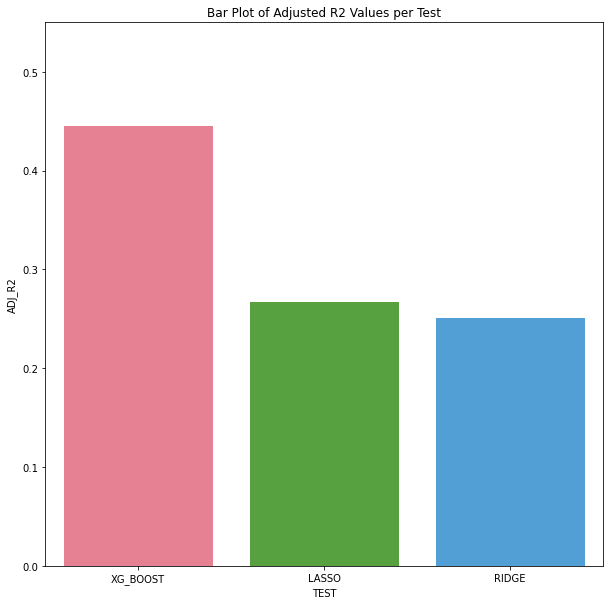

In [266]:
#bar plot of adjusted R2 per test

ax = sns.barplot(x=results_df.TEST,y=results_df.ADJ_R2, palette = 'husl').set_title("Bar Plot of Adjusted R2 Values per Test")
plt.ylim(0.0, 0.55)
fig = ax.get_figure()
fig.savefig("Bar_Plot_ADJ_R2.png")

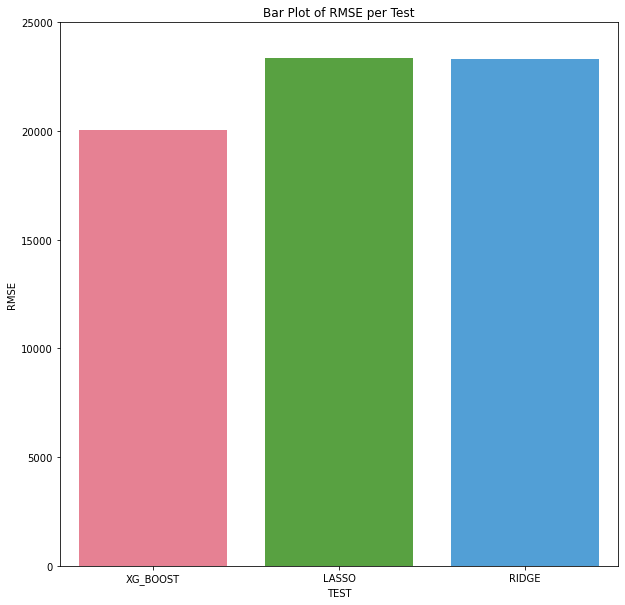

In [267]:
#bar plot of RMSE per test

ax4= sns.barplot(x=results_df.TEST,y=results_df.RMSE, palette = 'husl').set_title("Bar Plot of RMSE per Test")
plt.ylim(0, 25000)
fig = ax4.get_figure()
fig.savefig("Bar_Plot_RMSE.png")


In [268]:
#Create final training set for XGBoost Train on both train & val data 

x_frames = [X_train, X_val]
y_frames = [y_train, y_val]

X_training = pd.concat(x_frames)
y_training = pd.concat(y_frames)




In [269]:
#Tuning Parameters for XG Boost 

#Convert data into DMatrix
glass_dmatrix = xgb.DMatrix(data = X_training, label = y_training)

# Grid of hyperparameters to search over
param_random_gb = {'learning_rate': np.arange(0.05,1.05, 0.05),
              'n_estimators' : [200],
              'subsample' : np.arange(0.05,1.05, 0.05),
                  'alpha': (0.05, 0.1, 0.2, 0.3, 0.5)}

# Regressor Instantiation
gb = xgb.XGBRegressor()

# 25 iterations
mse_random = RandomizedSearchCV(estimator = gb, param_distributions = param_random_gb, n_iter = 25, 
                                scoring = 'neg_mean_squared_error', cv = 4, verbose = 1)

mse_random.fit(X,y)

print("Best parameter: ", mse_random.best_params_)
print("Lowest RMSE: ", np.sqrt(np.abs(mse_random.best_score_)))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameter:  {'subsample': 0.3, 'n_estimators': 200, 'learning_rate': 0.05, 'alpha': 0.2}
Lowest RMSE:  18809.938135791057


In [271]:
#Train final XG Boost Model
xgbr = xgb.XGBRegressor(verbosity=0, eta=0.05, sub_sample=0.3, n_estimators=200, alpha=0.2) 
xgbr.fit(X_training, y_training)


#predict y values 
y_pred = xgbr.predict(X_test)

#derive mse, score, mae and adjusted r2
mse = mean_squared_error(y_test, y_pred)
score = xgbr.score(X_test, y_test)
xgb_mae = mae(y_test, y_pred)

#get adjust r2 for the model 
#Adj r2 = 1-(1-R2)*(n-1)/(n-p-1)
adj_r2 = 1-(1-score) * (261-1)/(261-28-1)

print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("MAE Score %.2f" % xgb_mae)
print ("R2 Score: %.2f" % score )
print("Adjusted R2 Score: %.2f" % adj_r2)

results_df.loc[3] = ["XG_BOOST_FINAL", 28, 261, 0.3, xgb_mae,
             mse**(1/2.0), score, adj_r2]
results_df.head()

MSE: 263185721.03
RMSE: 16223.00
MAE Score 10686.41
R2 Score: 0.65
Adjusted R2 Score: 0.61


,TEST,FEAT,OBS,ALPHA,MAE,RMSE,R2,ADJ_R2
0,XG_BOOST,28,261,0.500000,13268.799419,20049.646987,0.504787,0.445019
1,LASSO,21,261,178.752553,17673.359690,23379.601917,0.326631,0.267465
2,RIDGE,28,261,23.644894,17588.233739,23294.030979,0.331551,0.250876
3,XG_BOOST_FINAL,28,261,0.300000,10686.413928,16222.999754,0.650888,0.608754


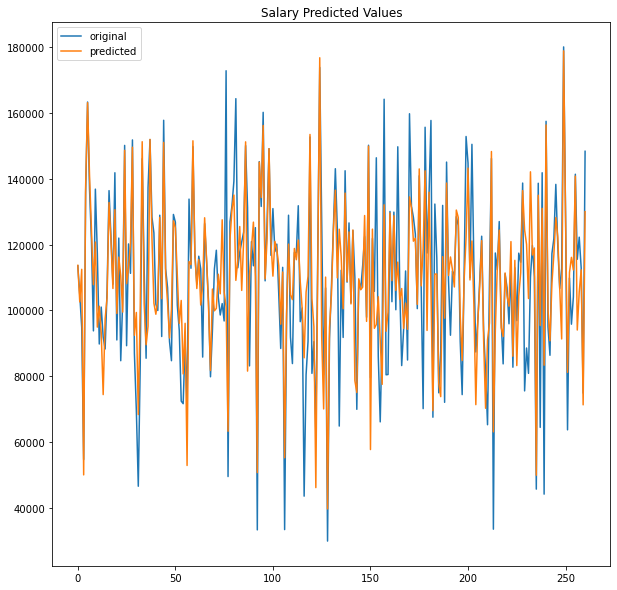

In [272]:
#plot the predictions 

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Salary Predicted Values")
plt.legend()
plt.show()

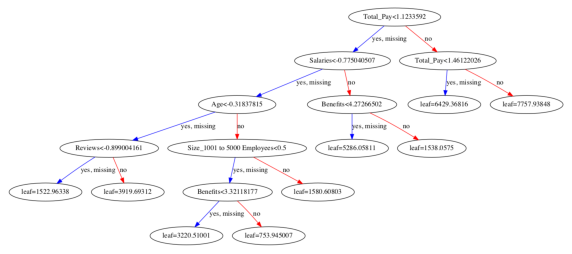

In [273]:
xgb.plot_tree(xgbr,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 50]
plt.show()

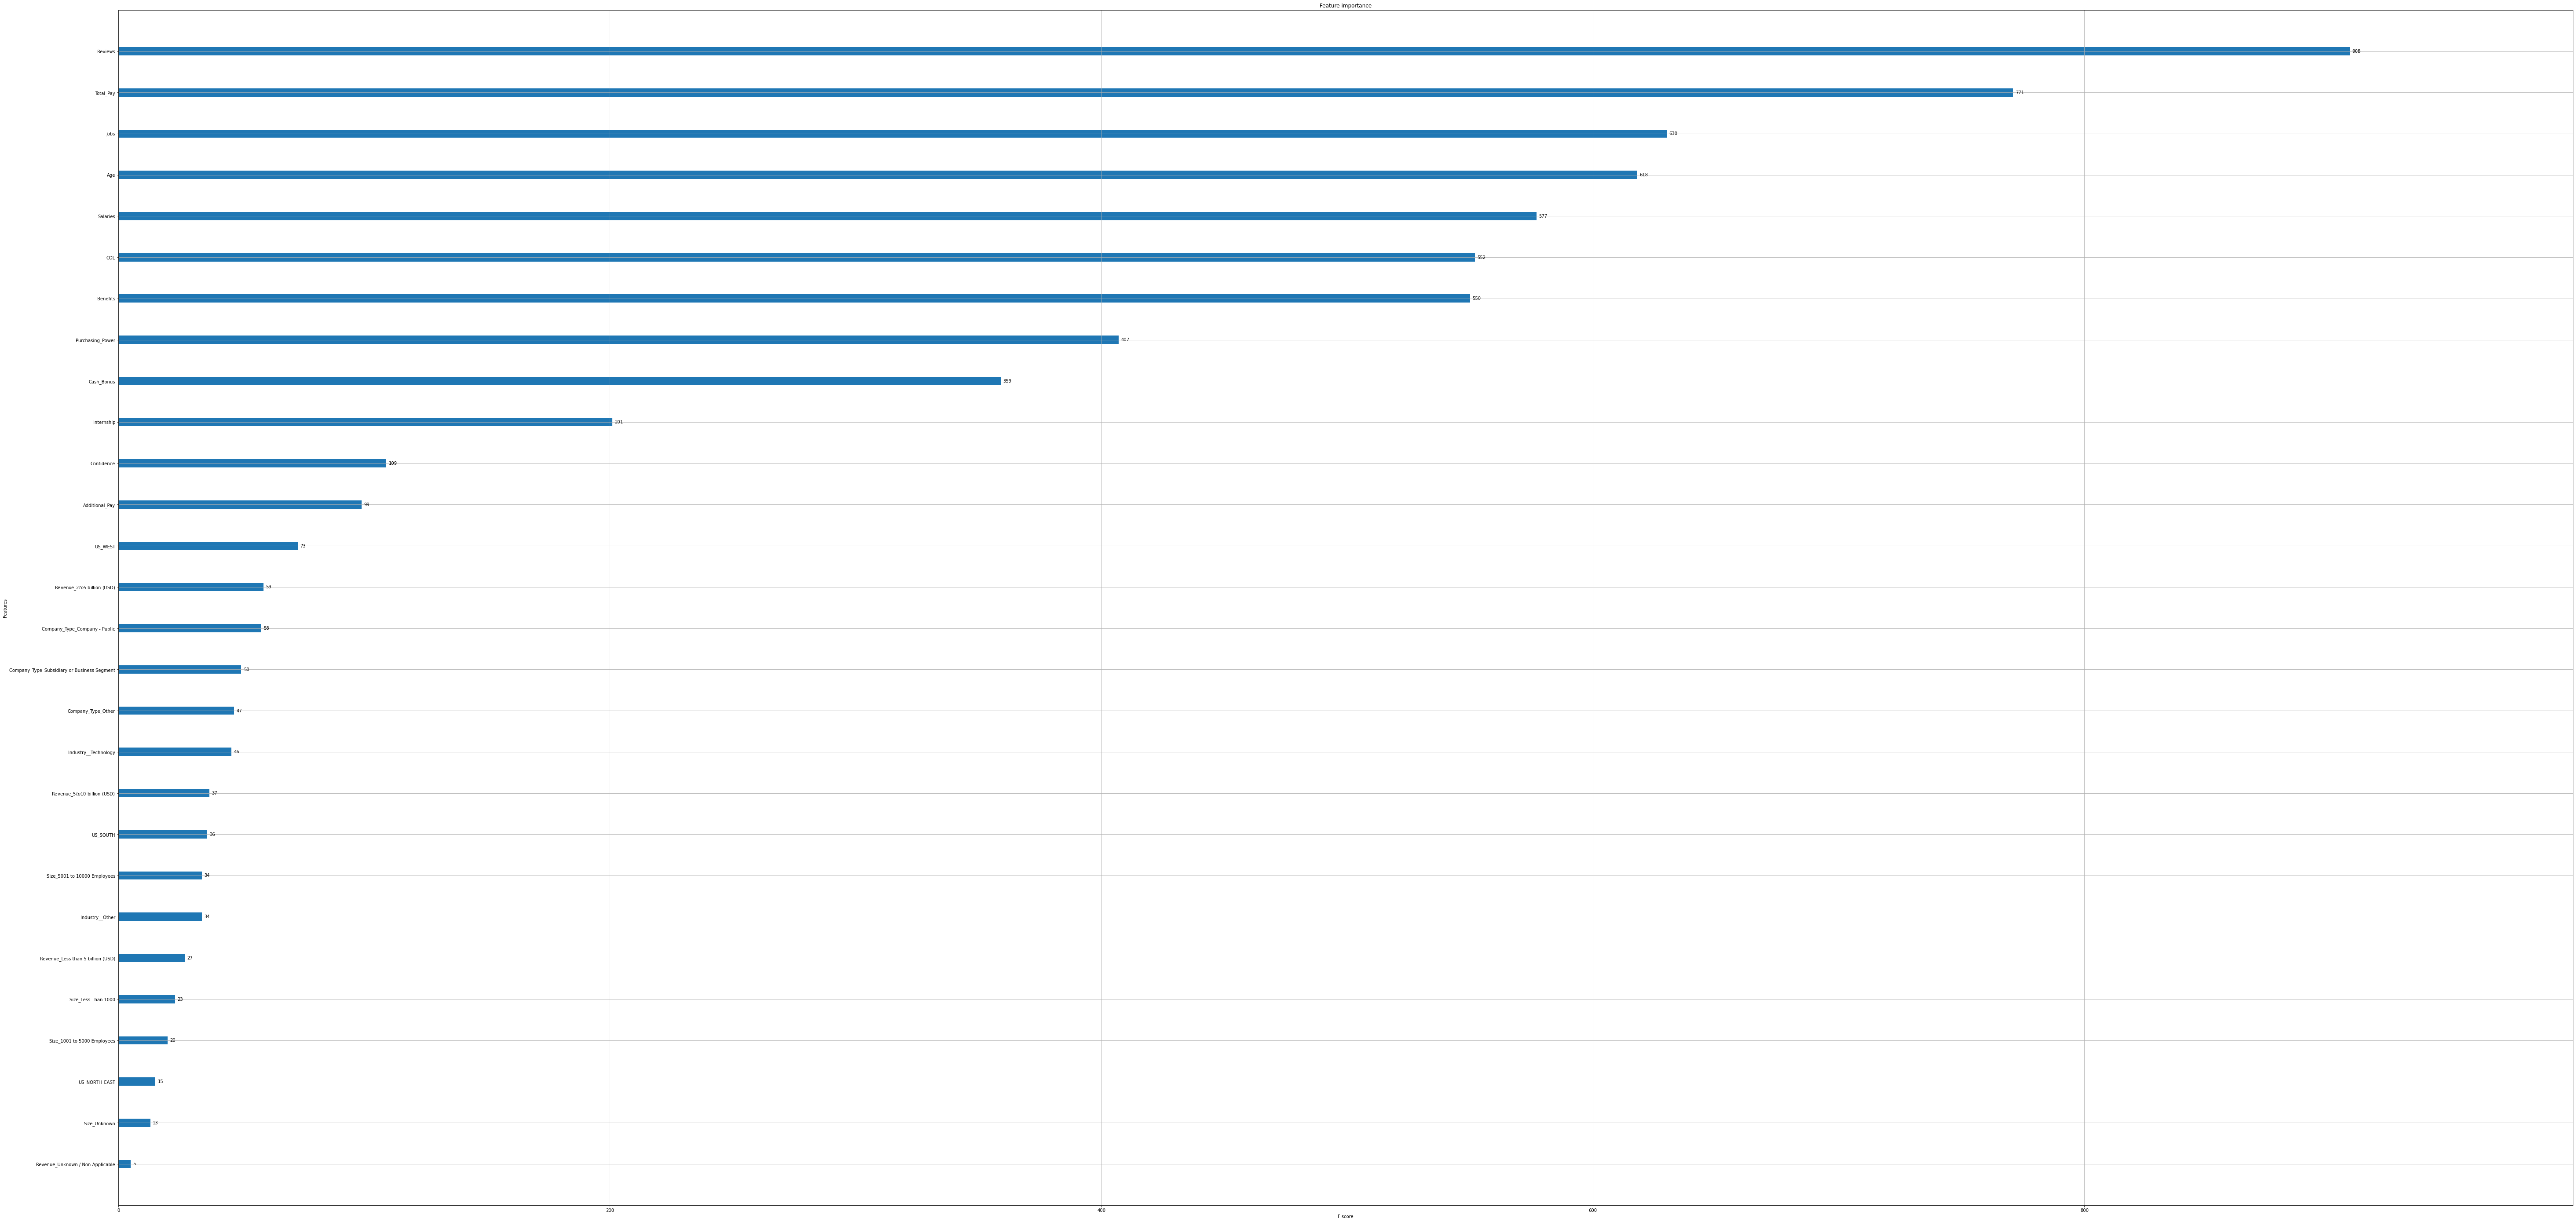

In [274]:
xgb.plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

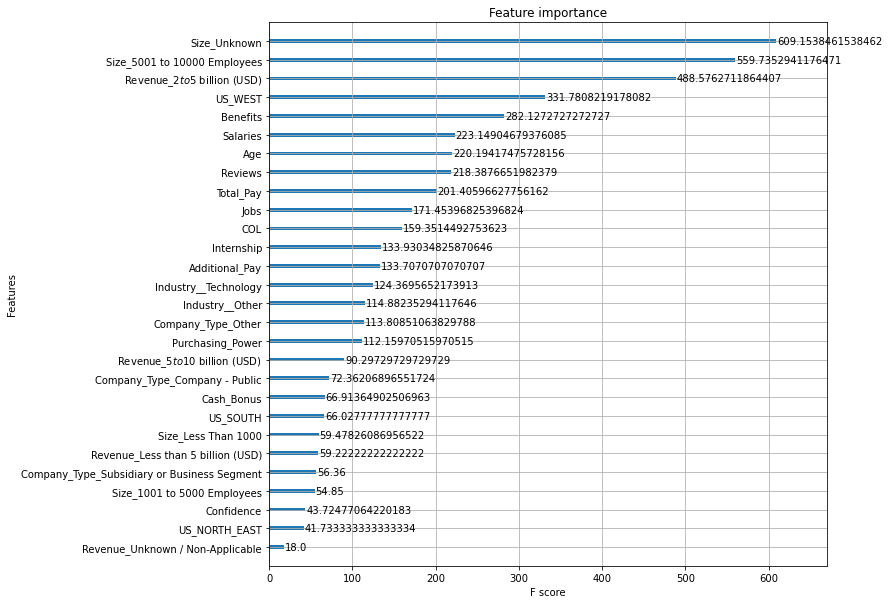

In [275]:
xgb.plot_importance(xgbr, importance_type="cover")
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

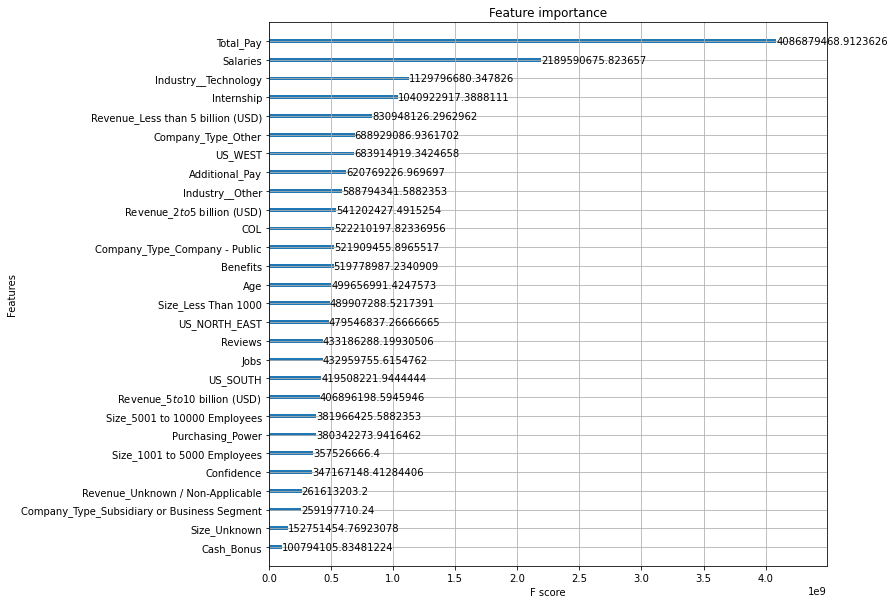

In [276]:
xgb.plot_importance(xgbr, importance_type="gain")
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


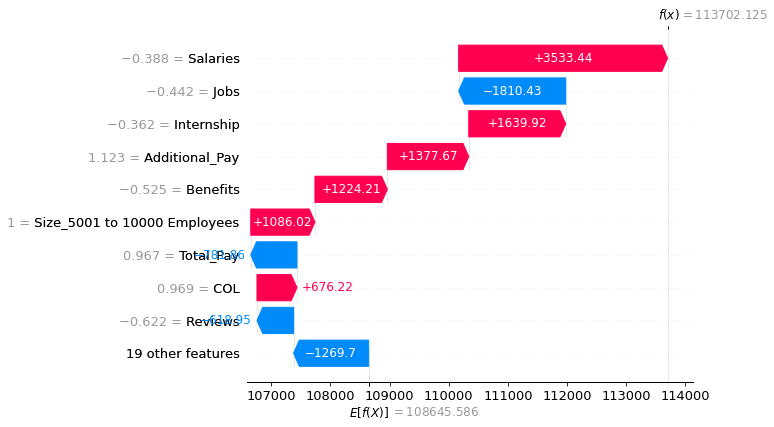

In [277]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(xgbr)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

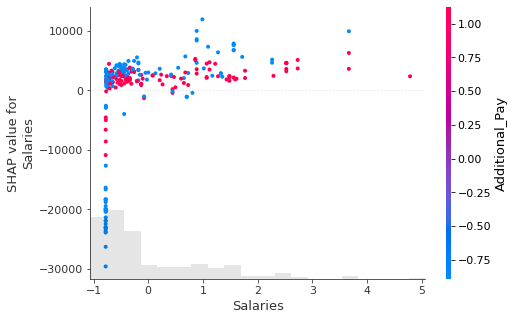

In [278]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"Salaries"], color=shap_values)

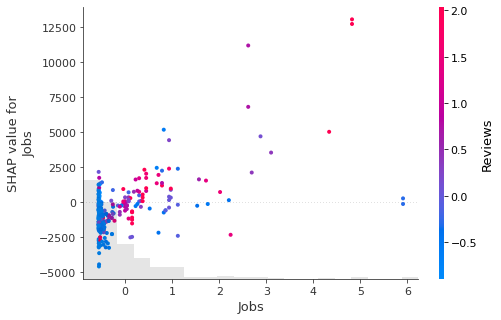

In [279]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"Jobs"], color=shap_values)

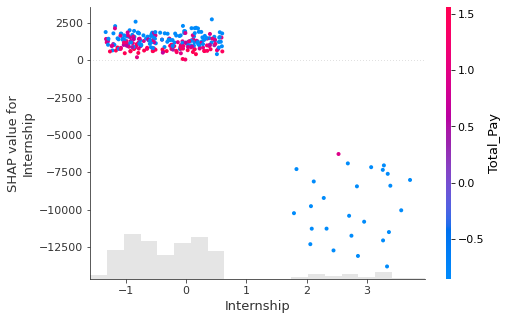

In [280]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,'Internship'], color=shap_values)

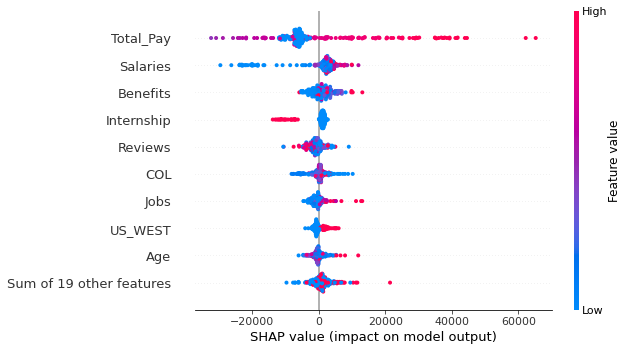

In [281]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

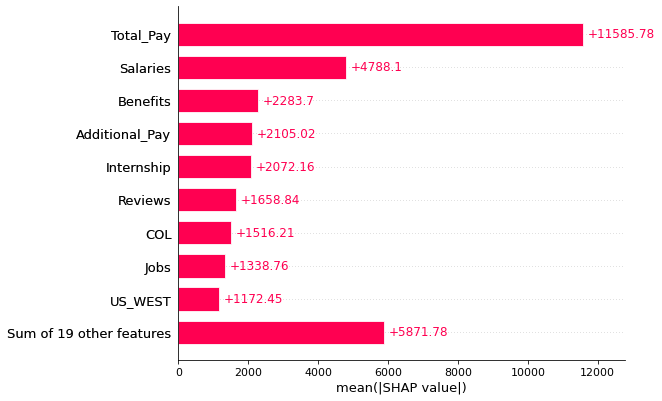

In [282]:
shap.plots.bar(shap_values)